In [1]:
import catboost
from catboost import CatBoostClassifier
import ROOT
import numpy as np
import uproot
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.22/06


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-1ibu_txp because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def load_model(trained_model=""):
    from_file = CatBoostClassifier()
    from_file.load_model(trained_model)
    return from_file

# def load_data(iev):
#     keys = ['nPhotons',
#             'nHadrons',
#              'gE',
#              'gTheta',
#              'gPhi',
#              'g_pcal_e',
#              'g1_pcal_e',
#              'g2_pcal_e',
#              'g_pcal_du',
#              'g_pcal_dv',
#              'g_pcal_m2u',
#              'g_pcal_m2v',
#              'g_pcal_m3u',
#              'g_pcal_m3v',
#              'g1R',
#              'g2R',
#              'g1M',
#              'g2M',
#              'g1dE',
#              'g2dE',
#              'h1R',
#              'h2R',
#              'h1M',
#              'h2M',
#              'h1dE',
#              'h2dE',
#              'h1q',
#              'h2q',
#              'eR',
#              'eM',
#              'edE']
    
#     ret = []
#     for key in keys:
#         exec("ret.append(iev.{})".format(key))
    
#     return ret

def load_data(input_file):
    keys = ['ievent','nPhotons',
            'nHadrons',
             'gE',
             'gTheta',
             'gPhi',
             'g_pcal_e',
             'g1_pcal_e',
             'g2_pcal_e',
             'g_pcal_du',
             'g_pcal_dv',
             'g_pcal_m2u',
             'g_pcal_m2v',
             'g_pcal_m3u',
             'g_pcal_m3v',
             'g1R',
             'g2R',
             'g1M',
             'g2M',
             'g1dE',
             'g2dE',
             'h1R',
             'h2R',
             'h1M',
             'h2M',
             'h1dE',
             'h2dE',
             'h1q',
             'h2q',
             'eR',
             'eM',
             'edE']
    
    t = uproot.open(input_file+":PreProcessedEvents")
    data = t.arrays(keys,library="pd")
    return data

def calc_diphotons(gVects):
    N = len(gVects)
    Mgg=[]
    if(N<=1):
        return Mgg
    for i in range(N):
        g1=gVects[i]
        for j in range(i+1,N):
            g2=gVects[j]
            Mgg.append((g1+g2).M())
            
    return Mgg

In [3]:
f = ROOT.TFile("/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/preprocess_catboost/MC_3051_0.root","READ")
t = f.Get("PreProcessedEvents")

In [4]:
X = load_data("/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/preprocess_catboost/MC_3051_0.root")

model=load_model("models/test")
threshold=0.9

X["prob"]=model.predict_proba(X)[:,1]

In [68]:




current_ievent=0
gVects_thresh=[]
gVects_tot=[]
Mdiphoton_tot=[]
Mdiphoton_thresh=[]
for i,iev in X.iterrows():
    if(i==0):
        current_ievent==iev.ievent
    if(iev.ievent!=current_ievent): # Begin diphoton analysis
        current_ievent=iev.ievent
        Mdiphoton_thresh = Mdiphoton_thresh + calc_diphotons(gVects_thresh)
        Mdiphoton_tot = Mdiphoton_tot + calc_diphotons(gVects_tot)
        gVects_tot=[]
        gVects_thresh=[]
    if(iev.ievent==current_ievent): # event hasn't changed, keep accumulating particles
        pred=iev.prob
        th=iev.gTheta
        phi=iev.gPhi
        p=iev.gE
        px=p*np.sin(th)*np.cos(phi)
        py=p*np.sin(th)*np.sin(phi)
        pz=p*np.cos(th)
        gVects_tot.append(ROOT.TLorentzVector(px,py,pz,p))
        if(pred>=threshold): # If this photon is likely signal, add to list
            gVects_thresh.append(ROOT.TLorentzVector(px,py,pz,p))
    if(i%10000==0):
        print(i,"/",len(X))

0 / 164191
10000 / 164191
20000 / 164191
30000 / 164191
40000 / 164191
50000 / 164191
60000 / 164191
70000 / 164191
80000 / 164191
90000 / 164191
100000 / 164191
110000 / 164191
120000 / 164191
130000 / 164191
140000 / 164191
150000 / 164191
160000 / 164191


In [71]:
Mdiphoton_bkg = list(set(Mdiphoton_tot) - set(Mdiphoton_thresh))

(array([ 7474., 12264., 11877.,  9310.,  6877.,  4779.,  3547.,  2670.,
         2167.,  1863.,  1586.,  1410.,  1419.,  1346.,  1369.,  1360.,
         1441.,  1382.,  1490.,  1508.,  1576.,  1677.,  1667.,  1802.,
         1901.,  1930.,  1988.,  1942.,  2018.,  1909.,  1786.,  1689.,
         1616.,  1601.,  1540.,  1474.,  1465.,  1417.,  1396.,  1342.,
         1326.,  1243.,  1248.,  1203.,  1218.,  1173.,  1089.,  1124.,
         1046.,  1029.]),
 array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
        0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
        0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
        0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
        0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
        0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 ]),
 [<matplotlib.patches.Polygon at 0x7f8ce5bbd490>])

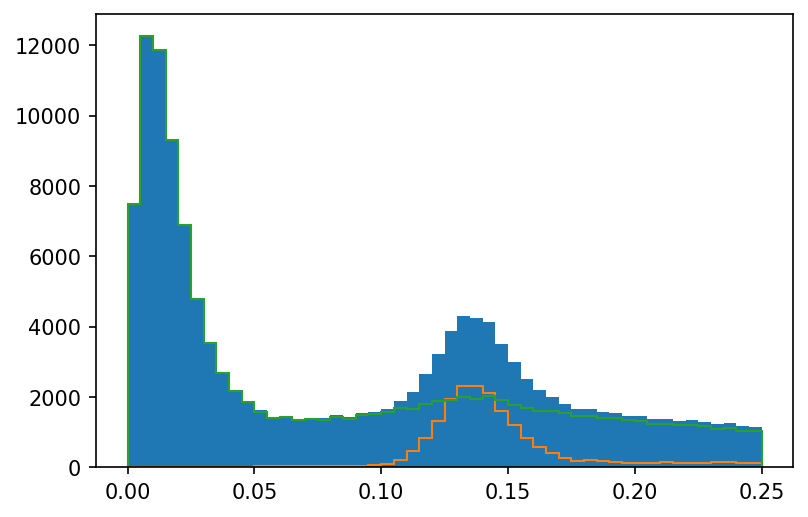

In [77]:
plt.figure(dpi=150)
plt.hist(Mdiphoton_tot,bins=50,range=(0,0.25))
plt.hist(Mdiphoton_thresh,bins=50,histtype=u'step',range=(0,0.25))
plt.hist(Mdiphoton_bkg,bins=50,histtype=u'step',range=(0,0.25))